### Задание
Необходимо
1) произвести предобработку данных,
2) обучить решающие деревья с различными параметрами,
3) оценить модели с помощью рассмотренных метрик, объяснить выбор определенной метрики и аргументировать выбор настроек алгоритма (подбор гиперпараметров).

### Решение
#### Предобработка данных
описание набора данных (взято отсюда: https://www.kaggle.com/competitions/spaceship-titanic/data):

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.



In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [284]:
df = pd.read_csv('./data/spaceship_titanict_rain.csv')

In [285]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


PassengerId не содержит пропусков, но в таком формате мало информативен. Лучше выделить номер группы отдельно, а номер внутри группы тоже отдельно

In [287]:
def get_group_id(PassengerId):
    return int(PassengerId[:4])

def get_id_within_group(PassengerId):
    return int(PassengerId[-2:])

df['GroupID'] = df['PassengerId'].apply(get_group_id)
df['IdWithinGroup'] = df['PassengerId'].apply(get_id_within_group)

df.drop(['PassengerId'], axis=1 ,inplace=True)

HomePlanet

In [288]:
df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [289]:
# Просто пропущенные значения заполним наиболее частым
df['HomePlanet'] = df['HomePlanet'].astype('category')
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].value_counts().idxmax())

CryoSleep, то же самое

In [290]:
df['CryoSleep'] = df['CryoSleep'].astype('bool')
df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].value_counts().idxmax())

Cabin разделим на 3 отдельных столбца

In [291]:
#deck/num/side, where side can be either P for Port or S for Starboard
def get_deck(Cabin):
    l = Cabin.split('/')
    return l[0]

def get_num(Cabin):
    l = Cabin.split('/')
    return l[1]

def get_side(Cabin):
    l = Cabin.split('/')
    return l[2]


df['Deck'] = df[df['Cabin'].notna()]['Cabin'].apply(get_deck)
df['Num'] = df[df['Cabin'].notna()]['Cabin'].apply(get_num)
df['Side'] = df[df['Cabin'].notna()]['Cabin'].apply(get_side)

In [292]:
df['Deck'] = df['Deck'].astype('category')
df['Side'] = df['Side'].astype('category')

df['Deck'] = df['Deck'].fillna(df['Deck'].value_counts().idxmax())
df['Side'] = df['Side'].fillna(df['Side'].value_counts().idxmax())

In [293]:
df['Num'] = df[df['Num'].notna()]['Num'].astype('int')
df['Num'] = df['Num'].fillna(df['Num'].median())
df['Num'] = df['Num'].astype('int')

In [294]:
df.drop(['Cabin'], axis=1 ,inplace=True)

Destination

In [295]:
df['Destination'] = df['Destination'].astype('category')
df['Destination'] = df['Destination'].fillna(df['Destination'].value_counts().idxmax())


Age

In [296]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

VIP

In [297]:
df['VIP'] = df['VIP'].astype('bool')

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: пустые значения заполняем нулями	

In [298]:
df['RoomService'] = df['RoomService'].fillna(0.0)
df['FoodCourt'] = df['FoodCourt'].fillna(0.0)
df['ShoppingMall'] = df['ShoppingMall'].fillna(0.0)
df['Spa'] = df['Spa'].fillna(0.0)
df['VRDeck'] = df['VRDeck'].fillna(0.0)

In [299]:
# удаляем Name
df.drop(['Name'], axis=1 ,inplace=True)

In [300]:
# конвертируем все категориальные признаки в числовые
from sklearn.preprocessing import LabelEncoder

for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [301]:
#посмотрим что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   HomePlanet     8693 non-null   int64
 1   CryoSleep      8693 non-null   int64
 2   Destination    8693 non-null   int64
 3   Age            8693 non-null   int64
 4   VIP            8693 non-null   int64
 5   RoomService    8693 non-null   int64
 6   FoodCourt      8693 non-null   int64
 7   ShoppingMall   8693 non-null   int64
 8   Spa            8693 non-null   int64
 9   VRDeck         8693 non-null   int64
 10  Transported    8693 non-null   int64
 11  GroupID        8693 non-null   int64
 12  IdWithinGroup  8693 non-null   int64
 13  Deck           8693 non-null   int64
 14  Num            8693 non-null   int64
 15  Side           8693 non-null   int64
dtypes: int64(16)
memory usage: 1.1 MB


<AxesSubplot:>

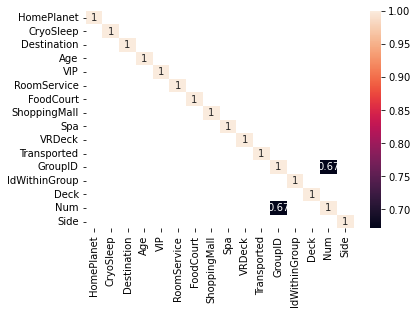

In [302]:
#теперь проверим взаимную корреляцию
import seaborn as sns
sns.heatmap(df.corr()[df.corr() > 0.6], annot=True)

#### Обучение с различными параметрами
параметры:
* max_depth - максимальная глубина дерева
* min_samples_leaf - минимальное количество элементов, которое может находиться в листовой вершине дерева
* min_samples_split - минимальное количество элементов, которое должно попасть в вершину, чтобы её можно было разделить

In [303]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [304]:
X = df.drop('Transported', axis=1).to_numpy()
y = df['Transported'].to_numpy()

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [306]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [307]:
predictions = clf.predict(X_test)
accuracy_score(predictions, y_test)

0.7516099356025759

### Оценка модели с помощью рассмотренных метрик, объяснить выбор определенной метрики и аргументировать выбор настроек алгоритма (подбор гиперпараметров).

In [308]:
max_depth = []
min_samples_leaf = []
min_samples_split = []
accuracy_scr = []


for max_depth_ in range(1,12):
    for min_samples_leaf_ in range(1,12):
        for min_samples_split_ in range(2,12):
            clf = DecisionTreeClassifier(random_state=13,
                 max_depth=max_depth_, 
                 min_samples_leaf=min_samples_leaf_, 
                 min_samples_split=min_samples_split_)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)

            max_depth.append(max_depth_)
            min_samples_leaf.append(min_samples_leaf_)
            min_samples_split.append(min_samples_split_)
            accuracy_scr.append(accuracy_score(predictions, y_test))

In [309]:
# посмотрим, на каких параметрах получается большая точность
max_accuracy = max(accuracy_scr)
indx = accuracy_scr.index(max_accuracy)
print(f'Максимальная точность accuracy : {max_accuracy} достигается при значениях параметров')
print(f'max_depth: {max_depth[indx]}') 
print(f'min_samples_leaf: {min_samples_leaf[indx]}')
print(f'min_samples_split: {min_samples_split[indx]}') 


Максимальная точность accuracy : 0.7782888684452622 достигается при значениях параметров
max_depth: 8
min_samples_leaf: 1
min_samples_split: 7
